# Прогнозирование вероятности оттока пользователей для фитнес-центров

1. [Цель проекта](#purpose)
1. [Задачи проекта](#tasks)
3. [Подготовка данных к анализу](#prepare)
1. [Анализ данных](#analysis)
1. [Mодель прогнозирования оттока клиентов](#churn)
1. [Kластеризация клиентов](#clasters)
1. [Выводы](#summary)

## Цель проекта <a id="purpose"></a>

Разработать стратегию удержания клиентов фитнес-клуба. 

## Задачи проекта <a id="tasks"></a>

1. спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
1. сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
1. проанализировать основные признаки, наиболее сильно влияющие на отток;
1. сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
	1. выделить целевые группы клиентов;
	2. предложить меры по снижению оттока;
	3. определить другие особенности взаимодействия с клиентами.

## Подготовка данных к анализу <a id="prepare"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#pd.set_option('display.max_columns', 500)
from numpy import median
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
df=pd.read_csv('/datasets/gym_churn.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


## Анализ данных <a id="analysis"></a>

Посмотрим на датасет: есть ли в нем отсутствующие признаки.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Отсутствующих признаков нет. 

Изучим средние значения и стандартные отклонения.

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


In [5]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался. 

In [6]:
df.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

In [7]:
df_cat=df[['gender','Contract_period','Near_Location','Partner','Promo_friends','Phone','Group_visits']]
df_cat.head()

,gender,Contract_period,Near_Location,Partner,Promo_friends,Phone,Group_visits
0,1,6,1,1,1,0,1
1,0,12,1,0,0,1,1
2,0,1,1,1,0,1,0
3,0,12,1,1,1,1,1
4,1,1,1,1,1,1,0


In [8]:
df_num=df[['Age','Avg_additional_charges_total', 'Month_to_end_contract','Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month', 'Churn']]
df_num.head()

,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,29,14.227470,5.0,3,0.020398,0.000000,0
1,31,113.202938,12.0,7,1.922936,1.910244,0
2,28,129.448479,1.0,2,1.859098,1.736502,0
3,33,62.669863,12.0,2,3.205633,3.357215,0
4,26,198.362265,1.0,3,1.113884,1.120078,0


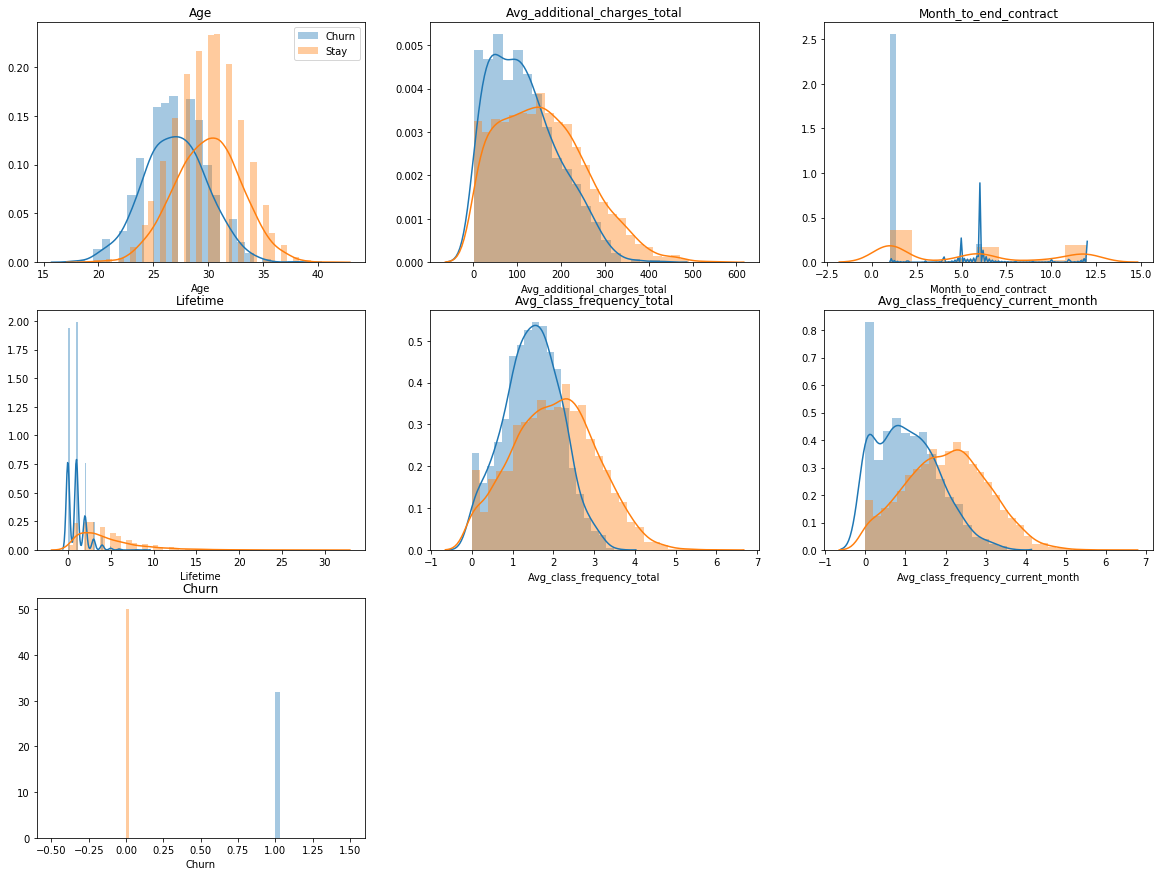

In [9]:
plt.subplots(figsize=(20,15))
num_cols=3
num_rows=len(df_num.columns.values)//num_cols + 1
for i, col in enumerate(df_num.columns.values):
    sns.distplot(df_num.query('Churn==1')[col], label ='Churn', ax=plt.subplot(num_rows,
                                                                          num_cols, i+1))
    sns.distplot(df_num.query('Churn==0')[col], label ='Stay')
    plt.title(col)
    if i ==0: plt.legend()

Вывод: 
- Люди более старшего возраста остаются больше (пик возраста ушедших - 25, пик оставшихся - 30).
- Посетители, заключившие договор на меньший срок уходят больше тех, кто платит за более длительные контракты, пропорции 2:1 у контарктов на 1 и 6 месяцев, также как и на 6 и 12 месяцев. 
- Посетители, тратящие больше в клубе, остаются больше. Среди тех, кто ушел, пик трат приходится на 100 единиц, среди тех, кто остался - на 200. 
- Пик оттока приходится за 1, 5, 6, и 11 месяцев до окончания абонемента. 
- Отток происходит больше в самом начале абонемента. 
- Уходящие клиенты посещали клуб в среднем чуть меньше двух раз в неделю, остающиеся - около трех раз в неделю за весь период. За последний месяц резкий пик на 0 посещений для ушедших, далее распределение между 1 и 2 визитами. Те, кто остались, посещали клуб 2-3 раза в неделю за последний месяц.  

Теперь посмотрим на распределения категориальных признаков. 

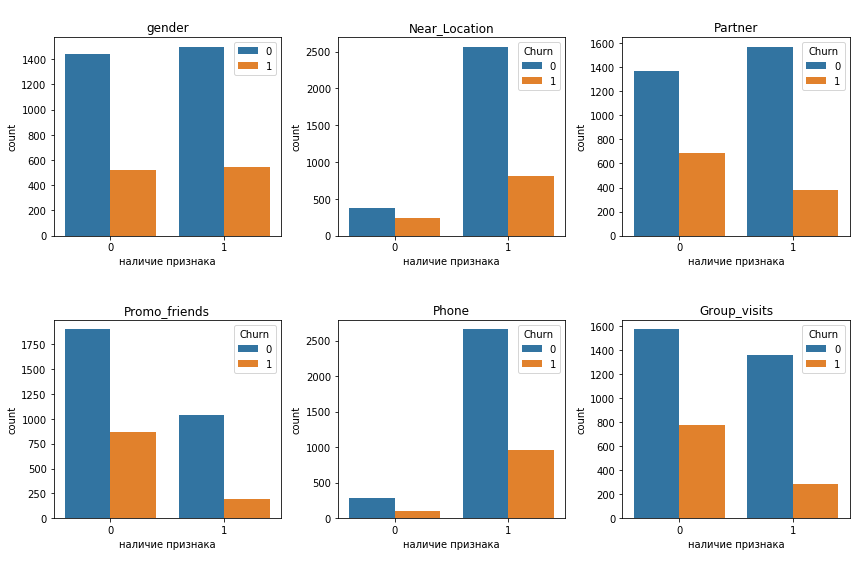

In [10]:
plt.subplots(figsize = (12, 8))
num_cols = 3
num_rows = 2

for i, col in enumerate(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits']):
    sns.countplot(x = df[col], hue='Churn', data=df, ax = plt.subplot(num_rows, num_cols, i+1))
    plt.title('\n' + col)
    plt.xlabel('наличие признака' + '\n')
    plt.tight_layout()
    if i == 0: plt.legend()

Вывод: 
- Люди, живущие ближе к клубу, остаются больше. 
- Оставшихся посетителей, пришедших по партнерской программе или по промо акции, больше тех, кто ушёл. 
- Если у клуба есть номер посетителя, он остаётся чаще. 
- Если посетитель ходит на групповые занятия, он остаётся чаще, чем тот, который не ходит. 

Построим матрицу корреляций.

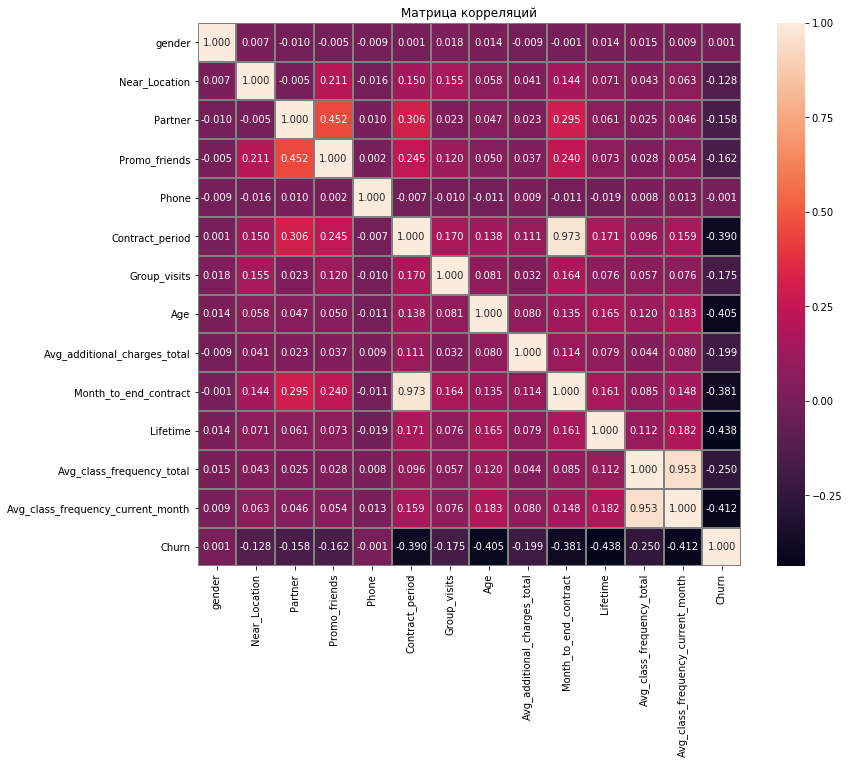

In [11]:
cm = df.corr()
plt.figure(figsize=(13, 10))
plt.title('Матрица корреляций')
sns.heatmap(cm, annot=True, square=True, fmt='.3f', linewidths=1, linecolor='gray') 
plt.show()

Вывод: 

Признаки, слишком сильно коррелирующие между собой: 
- продолжительность контракта и время, оставшееся до конца абонемента
- частота посещений в неделю за весь период и за последний месяц

Признаки со средней степенью влияния на отток клиента: 
- частота посещений клуба за последний месяц
- продолжительность абонемента и время оставшееся до конца абономента
- время прошедшее с первого визита клуба
- возраст 

Стоит удалить сильно коррелирующие между собой признаки, чтобы они не влияли на веса призаков при обучении. 

In [12]:
df.columns

Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
       'Churn'],
      dtype='object')

In [13]:
df=df.drop(columns=['Avg_class_frequency_total','Month_to_end_contract'])
df.columns

Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Lifetime',
       'Avg_class_frequency_current_month', 'Churn'],
      dtype='object')

## Модель прогнозирования оттока клиентов <a id="churn"></a>

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

Разделим данные на признаки и целевую переменну "отток клиентов", а потом разобьем данные на обучающую и валидационную выборку.

In [14]:
X = df.drop('Churn', axis=1) 
y = df['Churn'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y) 

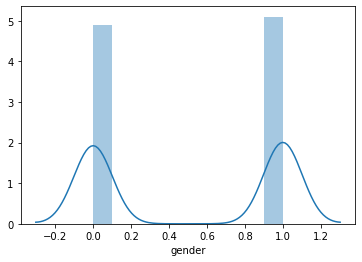

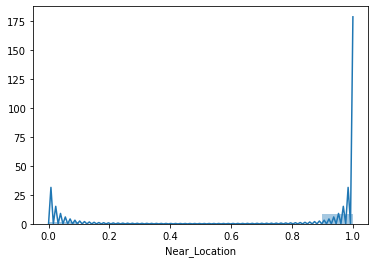

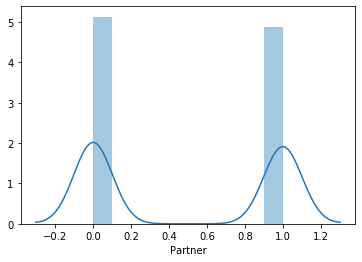

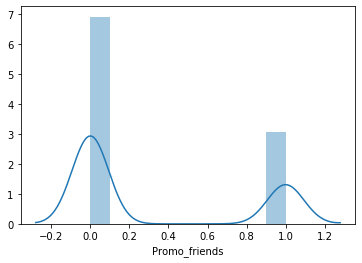

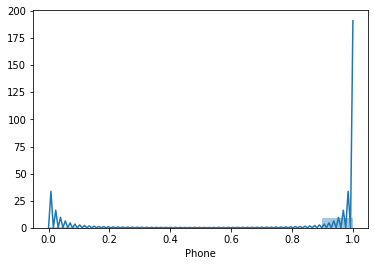

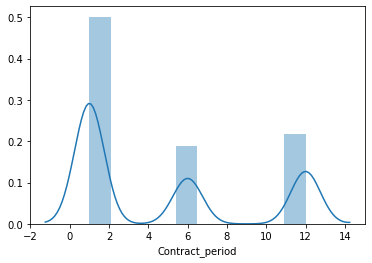

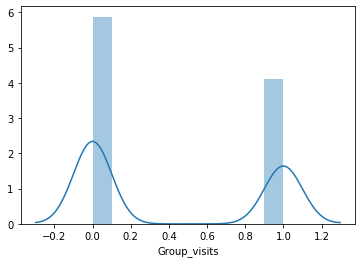

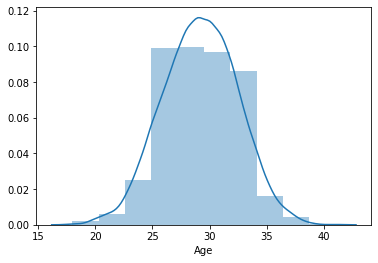

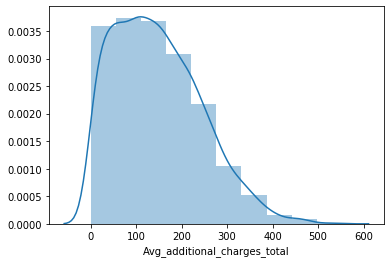

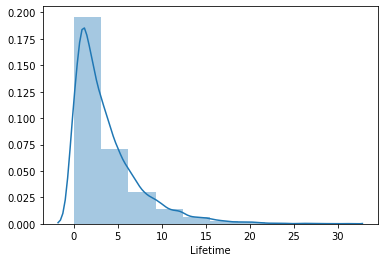

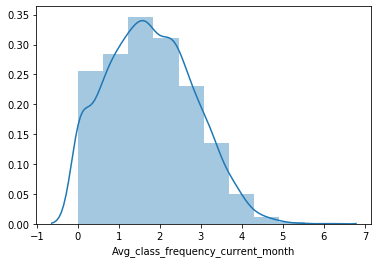

In [15]:
for feature in X_train.columns:
    sns.distplot(df[feature], bins = 10)
    plt.show() 

Стандартизируем данные.

In [16]:
scaler = StandardScaler() 
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

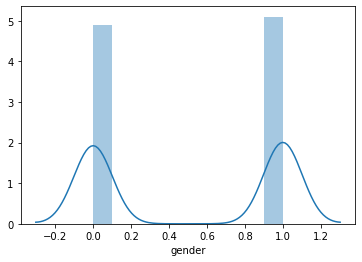

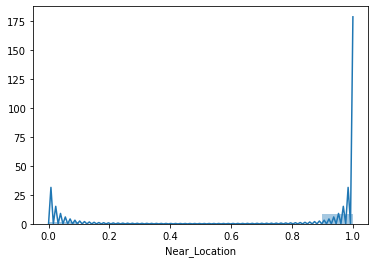

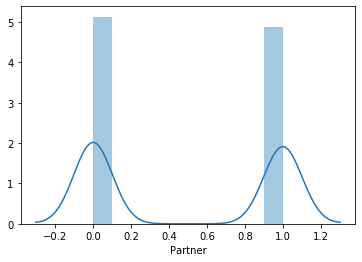

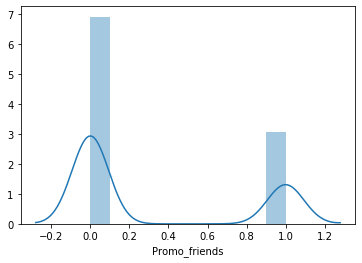

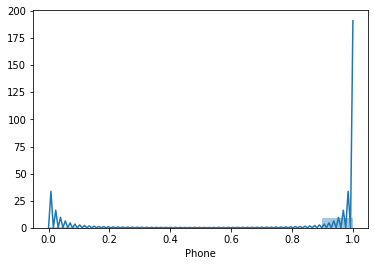

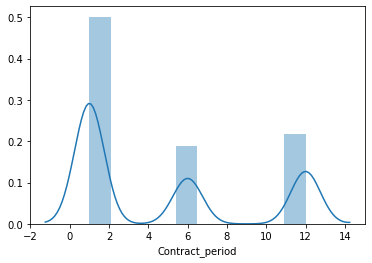

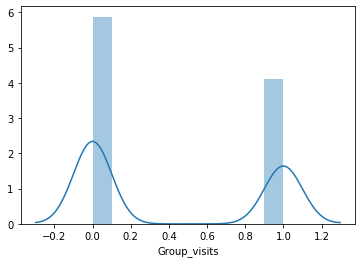

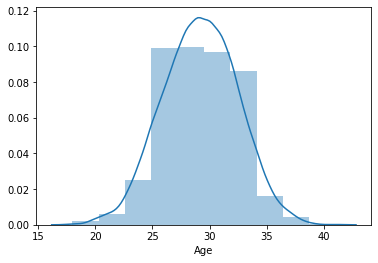

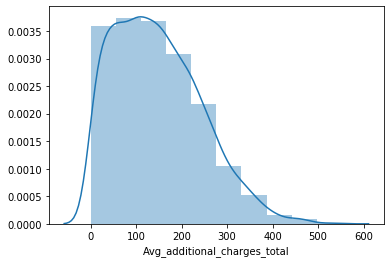

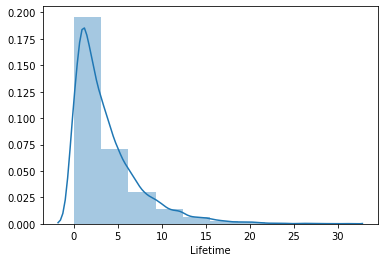

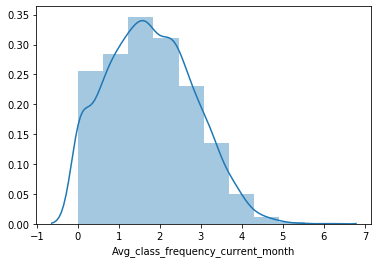

In [17]:
df_new = pd.DataFrame(data = X_train_st, columns = X_train.columns)
for feature in df_new.columns:
    sns.distplot(df[feature], bins = 10)
    plt.show() 

Обучим модель на train-выборке логистической регрессией.

In [18]:
lr_model = LogisticRegression(random_state=0) 
lr_model.fit(X_train_st, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Воспользуемся уже обученной моделью, чтобы сделать прогнозы

In [19]:
lr_predictions = lr_model.predict(X_test_st)

Обучим train-выборку моделью "Случайный лес" (Random forest)

In [20]:
rf_model = RandomForestClassifier (n_estimators=100, random_state=0)
rf_model.fit(X_train_st, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Сделаем прогнозы.

In [21]:
rf_predictions = rf_model.predict(X_test_st) 

Оценим результат двух моделей метриками accuracy, precision, recall и f1 на валидационной выборке.

In [22]:
print('Метрики для логистической регрессии')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test,lr_predictions))) 
print('Precision: {:.2f}'.format(precision_score(y_test, lr_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, lr_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, lr_predictions)))
print()
print('Метрики для случайного леса')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test,rf_predictions))) 
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))

Метрики для логистической регрессии
Accuracy: 0.92
Precision: 0.85
Recall: 0.84
F1: 0.84

Метрики для случайного леса
Accuracy: 0.91
Precision: 0.85
Recall: 0.77
F1: 0.81


Вывод: 
- Доля правильных ответов при обучении моделью "логическая регрессия" и "случайный лес" - 90% (но этот показатель не совсем подходит нам, потому что классы не сбалансированы, доля оттока явно меньше половины),
- точность предсказаний выше в случайном лесе: 79% для логической регресси и 81% для случайного леса
- полнота лучше в логической регрессии - 82% по сравнению с 75% в случайном лесе. 
- сбалансированная метрика дает 81% в логической регрессии и 78% в случайном лесе. 

Если нам важно отловить всех потенциально уходящих клиентов, то лучше ориентироваться на метрику полноты и логическая регрессия справилась с этой задачей лучше. Сводная метрика f1 так же указывает на большую успешность логической регрессии. 

## Кластеризация клиентов <a id="clasters"></a>

Стандартизируем таблицу без колонки со значением оттока. 

In [23]:
X_sc = scaler.fit_transform(X)

Построим для стандартизированных данных матрицу расстояний функцией linkage()

In [24]:
linked = linkage(X_sc, method = 'ward') 

Нарисуем дендрограмму.

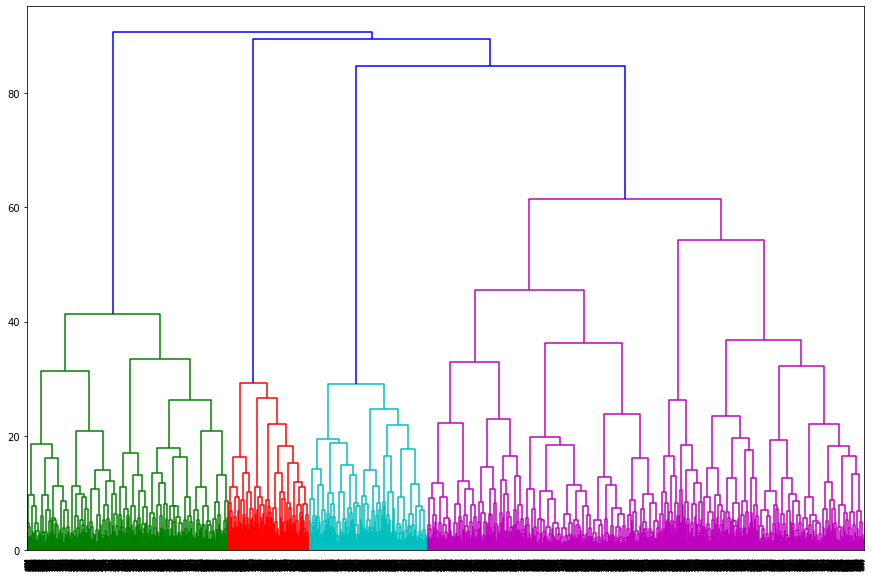

In [25]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

Образовались связки четырех цветов, хотя сиреневая такая большая, что её вполне тоже можно поделить попалам. Возможно, зеленую ветку тоже, так что максимум было бы оптимально задать 6, но не больше. Остановимся на 5 кластерах.

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов

In [26]:
km = KMeans(n_clusters = 5)
labels = km.fit_predict(X_sc)

In [27]:
df['labels']=labels
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_current_month,Churn,labels
0,1,1,1,1,0,6,1,29,14.227470,3,0.000000,0,4
1,0,1,0,0,1,12,1,31,113.202938,7,1.910244,0,1
2,0,1,1,0,1,1,0,28,129.448479,2,1.736502,0,2
3,0,1,1,1,1,12,1,33,62.669863,2,3.357215,0,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.120078,0,0


In [28]:
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette_score: 0.14


Метрика силуэта показывает, насколько объект своего кластера похож на свой кластер больше, чем на чужой. В нашем случае, не очень сильно. :)

Посмотрим на средние значения признаков для кластеров. 

In [29]:
df.groupby(['labels']).mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_current_month,Churn
labels,,,,,,,,,,,,
0,0.496454,0.995947,0.890578,1.000000,1.0,6.910841,0.523810,29.600811,153.546885,4.282675,1.920546,0.119554
1,0.547000,0.996000,0.383000,0.010000,1.0,6.209000,0.527000,30.639000,178.339235,5.405000,2.352689,0.017000
2,0.489242,1.000000,0.215154,0.070159,1.0,2.039289,0.289991,27.661366,117.590616,1.951356,1.181741,0.559401
3,0.500000,0.000000,0.489247,0.078853,1.0,2.994624,0.232975,28.679211,137.125763,2.974910,1.597146,0.403226
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.723967,0.266839


Посмотрим на кластер с самым высоким риском оттока ~0.57: они живут ближе других, редко бывают по партнерской программе или по акции, заключают контракт на минимальный период, редко ходят на групповые занятия, они самые молодые из кластеров, тратят меньше всех, меньше всех провели общего времени в клубе и были реже других в клубе за последний месяц. 

Кластер самых лояльных клиентов с риском оттока ~0.02: они тоже живут близко, примерно так же нечасто бывают по партнерским программам и акциям, но они заключают гораздо более длительные контракты, чаще посещают групповые занятия, они самые старшие в кластерах, тратят больше всех других, давно уже с клубом и чаще других приходили за последний месяц. 

Построим распределения признаков для кластеров

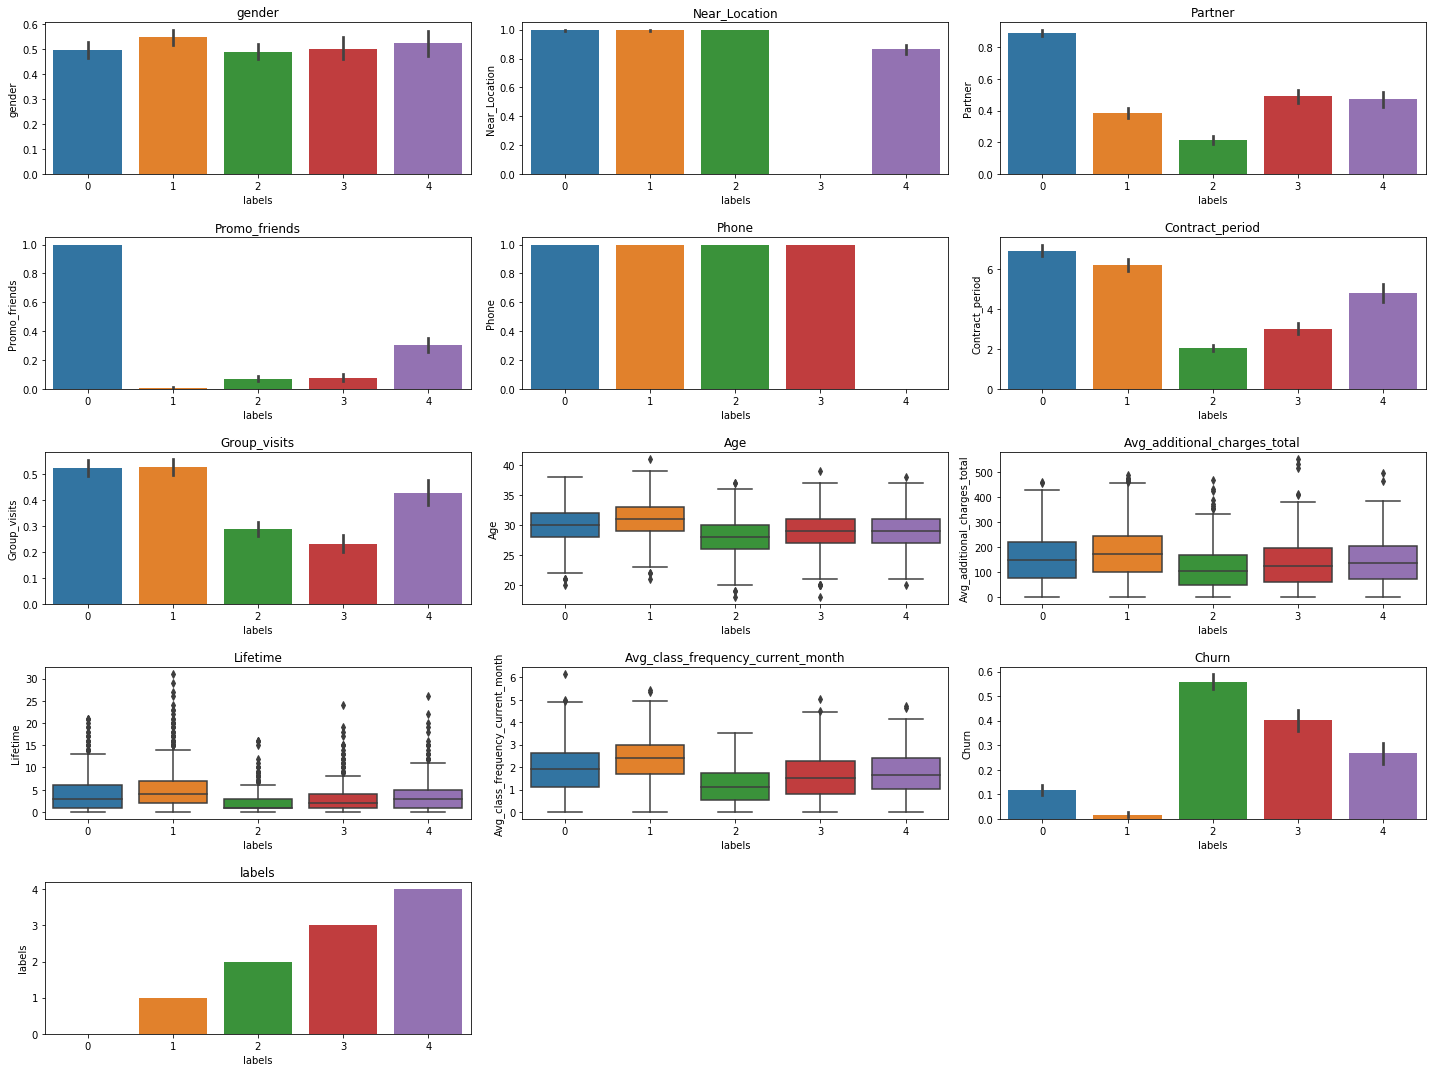

In [30]:
plt.subplots(figsize=(20,15))
plots_in_row=len(df_num.columns.values)//num_cols + 1
for i, col in enumerate(df.columns.values):
    ax=plt.subplot(len(df.columns.values)//plots_in_row +1,plots_in_row, i+1)
    if col in ['Age','Avg_additional_charges_total', 'Lifetime',
       'Avg_class_frequency_current_month']:
        sns.boxplot(data=df, x='labels', y=col, ax=ax)
    else:
        sns.barplot(data=df,x='labels', y=col, ax=ax)
    plt.title(col)
plt.tight_layout()
plt.show()

## Выводы <a id="summary"></a>

Рекомендации по работе с кластером, у которого самый большой риск оттока: 
   1. Мотивировать клиентов ходить на групповые занятия, например рекламируя тренеров. 
   2. Присылать клиенту напоминание о клубе, если он появлялся там больше недели назад. 
   3. Предлагать акции/скидки на продление за пару недель до окончания абонемента. 
   4. Ненавязчиво предлагать товары из бара. :) 
    
Стоит также привлекать клиентов, похожих по параметрам на кластер лояльных клиентов: людей ближе к 30 годам, живущих близко.      